In [1]:
using Suppressor

In [24]:
@suppress begin
    include("./Desktop/Code/PubMedAsthma/Functions.jl")
end;

In [3]:
@suppress begin
    include("./Desktop/Code/PubMedAsthma/Results.jl")
end;

In [4]:
mesh_descrips_ped

,count,mesh_descriptor,freq
1,48526,humans,0.9978619300193249
2,41303,asthma,0.9778791990460919
3,41150,child,0.8462645450433781
4,26149,male,0.5377246001397968
5,26019,female,0.535052012663953
6,21129,adolescent,0.43456272357222153
7,19981,"child, preschool",0.41087948686320463
8,11168,infant,0.2295958225401916
9,4618,risk factors,0.09497964721845319
10,4014,prevalence,0.08256239463837836


In [5]:
semantics_ped

,count,semantic_type,freq
1,71502,Disease or Syndrome,1.0
2,96794,Age Group,0.999794416348012
3,48526,Human,0.9978619300193249
4,29734,Organism Attribute,0.5583651987993915
5,29496,Population Group,0.5507586036758357
6,27136,Pharmacologic Substance,0.3820566588544879
7,24171,Research Activity,0.3538916985321327
8,23320,Quantitative Concept,0.29883639652974797
9,19700,Organic Chemical,0.2951358907939641
10,17381,Diagnostic Procedure,0.27589326096788785


In [6]:
mesh_descrips_adult

,count,mesh_descriptor,freq
1,23513,humans,1.0
2,39114,asthma,0.9765236252285969
3,19449,adult,0.8271594437119891
4,18006,male,0.7657891379237017
5,17769,female,0.7557096074511972
6,14018,middle aged,0.5961808361332029
7,6022,aged,0.2561136392633862
8,3549,forced expiratory volume,0.14706757963679667
9,2405,bronchial provocation tests,0.10062518606728194
10,2099,respiratory function tests,0.0881639943860843


In [7]:
semantics_adult

,count,semantic_type,freq
1,73397,Disease or Syndrome,1.0
2,23513,Human,1.0
3,35082,Age Group,0.9690809339514311
4,25095,Organism Attribute,0.81104070088887
5,18405,Population Group,0.7585165653042998
6,34267,Pharmacologic Substance,0.518266490877387
7,28676,Organic Chemical,0.4681240165015098
8,14397,Diagnostic Procedure,0.42095861863649897
9,11277,Research Activity,0.3398970782120529
10,9123,Quantitative Concept,0.251435376174882


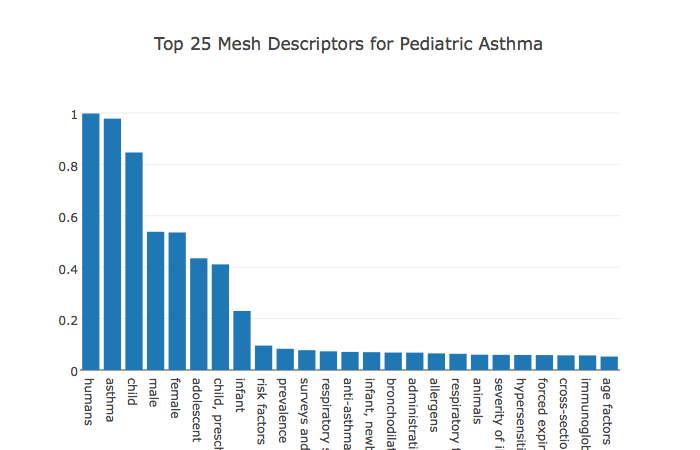

In [40]:
load("./Desktop/Code/PubMedAsthma/Plots/Top25MeshPed.pdf")

In [41]:
plot(bar(x=semantics_ped[1:10,:semantic_type], y=semantics_ped[1:10,:freq]),Layout(margin=1,title="Top 10 UMLS Semantic Types for Pediatric Asthma"))

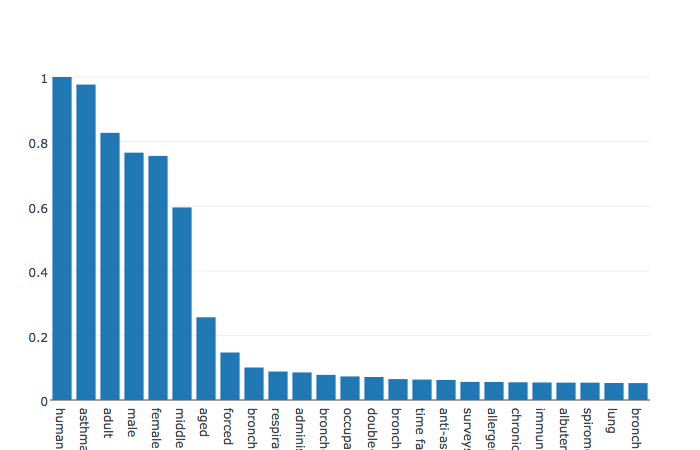

In [10]:
load("./Desktop/Code/PubMedAsthma/Plots/Top25MeshAdult.png")

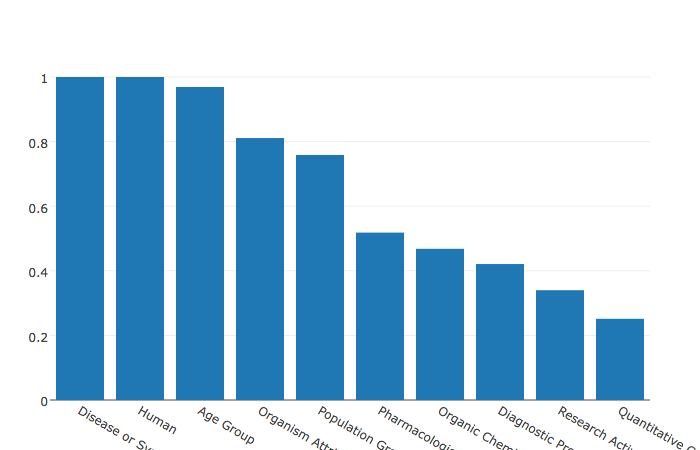

In [11]:
load("./Desktop/Code/PubMedAsthma/Plots/Top10SemanticsAdult.png")

In [12]:
mesh_descrips_filtered_ped

,count,mesh_descriptor,freq
1,41303,asthma,0.9778791990460919
2,1938,acute disease,0.03992434521606842
3,1880,chronic disease,0.03992434521606842
4,1225,"rhinitis, allergic, seasonal",0.031906582788536655
5,1126,bronchitis,0.031413182023765474
6,1269,"dermatitis, atopic",0.03108424818058468
7,1218,respiratory tract infections,0.03071419760700629
8,1162,"asthma, exercise-induced",0.028576127626331153
9,1199,bronchial hyperreactivity,0.028206077052752764
10,1042,"rhinitis, allergic, perennial",0.024464454586571274


In [13]:
mesh_descrips_filtered_adult

,count,mesh_descriptor,freq
1,39114,asthma,0.9765236252285969
2,2938,occupational diseases,0.07298090418066601
3,1309,chronic disease,0.0548207374643814
4,1700,bronchitis,0.0523114872623655
5,1520,bronchial hyperreactivity,0.040530770212223025
6,1542,"pulmonary disease, chronic obstructive",0.03627780376812827
7,786,acute disease,0.03342831625058478
8,1079,"lung diseases, obstructive",0.029898354101986137
9,888,"rhinitis, allergic, seasonal",0.02283842980478884
10,828,rhinitis,0.02177518819376515


In [14]:
association_rules_ped

,lhs,rhs,support,confidence,lift,chi_squared
1,asthma,"asthma, exercise-induced",0.015377657168701944,0.015725518227305217,0.5503026313759571,98.35382627735888
2,"asthma, exercise-induced",asthma,0.015377657168701944,0.5381294964028777,0.5503026313759571,98.35382627735846
3,asthma,chronic disease,0.039718761564080426,0.04061724761384182,1.0173553853926334,0.5348873853059547
4,chronic disease,asthma,0.039718761564080426,0.9948506694129763,1.0173553853926331,0.5348873853059417
5,asthma,"dermatitis, atopic",0.031002014719789483,0.0317033174956902,1.0199158529268273,0.4241386780227097
6,"dermatitis, atopic",asthma,0.031002014719789483,0.9973544973544973,1.019915852926827,0.42413867802270105
7,asthma,bronchitis,0.031289831832572675,0.03199764537694992,1.0186056717445013,0.3776879270760947
8,bronchitis,asthma,0.031289831832572675,0.9960732984293194,1.0186056717445013,0.377687927076094
9,asthma,bronchial hyperreactivity,0.027095925332017597,0.027708867678593953,0.9823722606575561,0.26274322361615005
10,bronchial hyperreactivity,asthma,0.027095925332017597,0.9606413994169096,0.9823722606575562,0.2627432236161465


In [15]:
association_rules_adult

,lhs,rhs,support,confidence,lift,chi_squared
1,"chronic disease,asthma",bronchitis,0.019478586313953983,0.35642023346303503,6.813421910094587,49.392766856912104
2,"bronchitis,asthma",chronic disease,0.019478586313953983,0.3729641693811075,6.803340973357626,49.298995647814905
3,bronchitis,chronic disease,0.019478586313953983,0.3723577235772358,6.792278630311516,49.195627889526016
4,chronic disease,bronchitis,0.019478586313953983,0.35531419705197825,6.7922786303115155,49.195627889526016
5,bronchitis,asthma,0.0522264279334836,0.9983739837398374,1.0223756578404597,1.411669928807167
6,asthma,bronchitis,0.0522264279334836,0.05348199120247376,1.0223756578404597,1.4116699288071577
7,chronic disease,asthma,0.05465061880661762,0.9968968192397207,1.0208629811760617,1.349392431344686
8,asthma,chronic disease,0.05465061880661762,0.05596446147815862,1.0208629811760617,1.3493924313446841
9,occupational diseases,asthma,0.07200272189852422,0.9865967365967366,1.0103152766690942,0.5899171198160348
10,asthma,occupational diseases,0.07200272189852422,0.07373372239885022,1.010315276669094,0.5899171198160135


In [16]:
mesh_descrips_filtered_ped[mesh_descrips_filtered_ped[:freq] .> .02,:]

,count,mesh_descriptor,freq
1,41303,asthma,0.9778791990460919
2,1938,acute disease,0.03992434521606842
3,1880,chronic disease,0.03992434521606842
4,1225,"rhinitis, allergic, seasonal",0.031906582788536655
5,1126,bronchitis,0.031413182023765474
6,1269,"dermatitis, atopic",0.03108424818058468
7,1218,respiratory tract infections,0.03071419760700629
8,1162,"asthma, exercise-induced",0.028576127626331153
9,1199,bronchial hyperreactivity,0.028206077052752764
10,1042,"rhinitis, allergic, perennial",0.024464454586571274


In [17]:
mesh_descrips_filtered_adult[mesh_descrips_filtered_adult[:freq] .> .02,:]

,count,mesh_descriptor,freq
1,39114,asthma,0.9765236252285969
2,2938,occupational diseases,0.07298090418066601
3,1309,chronic disease,0.0548207374643814
4,1700,bronchitis,0.0523114872623655
5,1520,bronchial hyperreactivity,0.040530770212223025
6,1542,"pulmonary disease, chronic obstructive",0.03627780376812827
7,786,acute disease,0.03342831625058478
8,1079,"lung diseases, obstructive",0.029898354101986137
9,888,"rhinitis, allergic, seasonal",0.02283842980478884
10,828,rhinitis,0.02177518819376515


In [18]:
mesh_fold(mesh_descrips_filtered_ped,mesh_descrips_filtered_adult)[1]

,mesh_descriptor,fold_ped
1,"bronchiolitis, viral",77.34221454709922
2,respiratory syncytial virus infections,16.6109983515929
3,virus diseases,10.634554500226143
4,bronchiolitis,10.074841105477397
5,"diabetes mellitus, type 1",9.264952784287926
6,cystic fibrosis,7.197122742577289
7,"dermatitis, atopic",6.35551241278337
8,eczema,6.174193831742864


In [19]:
mesh_fold(mesh_descrips_filtered_ped,mesh_descrips_filtered_adult)[2]

,mesh_descriptor,fold_adult
1,occupational diseases,45.51201463020456
2,"pulmonary disease, chronic obstructive",28.46169243369831
3,nasal polyps,16.12390892647622
4,churg-strauss syndrome,9.900340844882162
5,lung neoplasms,9.065895962433798
6,"lung diseases, obstructive",7.574561147025051
7,hypertension,7.18144126957124
8,pulmonary emphysema,6.315889082635138
9,"aspergillosis, allergic bronchopulmonary",5.689001828775571


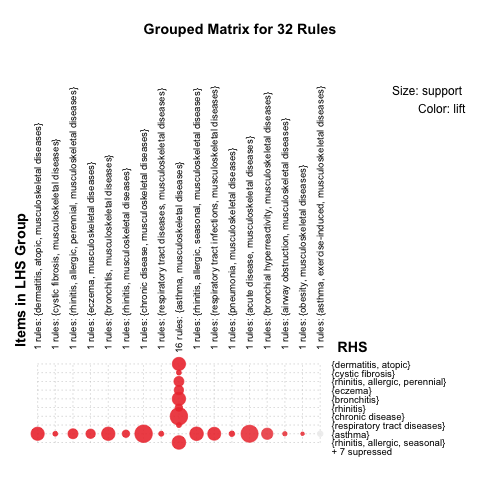

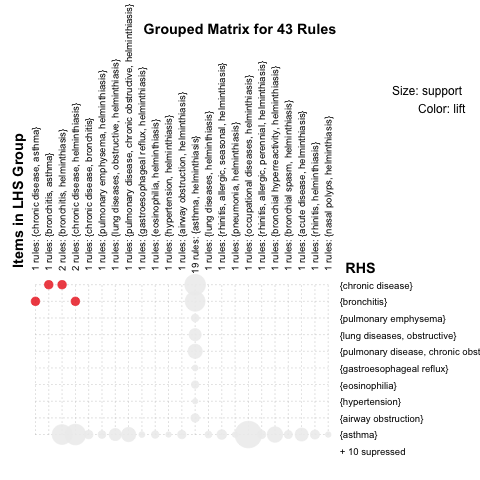

In [23]:
@suppress_err begin
    arules_viz(itemsets_ped)
    arules_viz(itemsets_adult)
end;

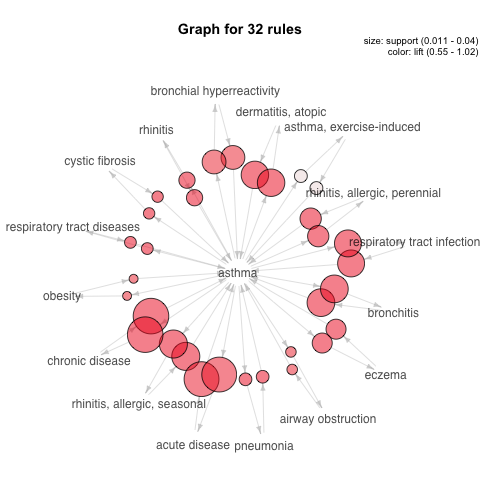

In [21]:
@suppress_err begin
    arules_viz(itemsets_ped, "graph")
end;

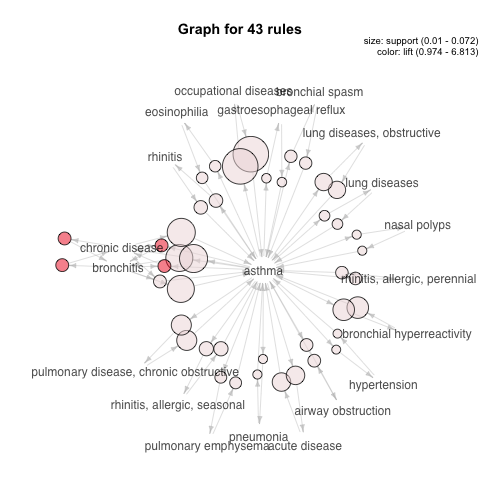

In [22]:
@suppress_err begin
    arules_viz(itemsets_adult, "graph")
end;